In [38]:
#!pip install torch torchvision torchaudio
#!pip install torch-geometric
#!pip install pandas scikit-learn


In [39]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

Load MovieLens 100k

In [40]:
ratings_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv(ratings_url, sep='\t', names=cols)
print(ratings_df.head(10))

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
5      298      474       4  884182806
6      115      265       2  881171488
7      253      465       5  891628467
8      305      451       3  886324817
9        6       86       3  883603013


In [41]:
# Check unique values for each column
unique_users = ratings_df['user_id'].nunique()
unique_items = ratings_df['item_id'].nunique()
unique_ratings = ratings_df['rating'].unique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique items: {unique_items}")
print(f"Unique rating values: {(unique_ratings)}")

rating_counts = ratings_df['rating'].value_counts().sort_index()
print("\nRating value counts:")
print(rating_counts)

# Check for null or empty values
is_users_null = pd.isna(unique_users) or unique_users == 0
is_items_null = pd.isna(unique_items) or unique_items == 0
is_ratings_null = pd.isna(unique_ratings).all() or len(unique_ratings) == 0

print(f"Is 'unique_users' null or zero? {is_users_null}")
print(f"Is 'unique_items' null or zero? {is_items_null}")
print(f"Is 'unique_ratings' all null or empty? {is_ratings_null}")

Number of unique users: 943
Number of unique items: 1682
Unique rating values: [3 1 2 4 5]

Rating value counts:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64
Is 'unique_users' null or zero? False
Is 'unique_items' null or zero? False
Is 'unique_ratings' all null or empty? False


Encode user and item IDs

In [42]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user'] = user_encoder.fit_transform(ratings_df['user_id'])
ratings_df['item'] = item_encoder.fit_transform(ratings_df['item_id'])

num_users = ratings_df['user'].nunique()
num_items = ratings_df['item'].nunique()


In [43]:
# Shift item indices to avoid collision
ratings_df['item'] += num_users

# Build edge index
edge_index = torch.tensor(ratings_df[['user', 'item']].values.T, dtype=torch.long)

# Optional: edge weights (ratings)
edge_weight = torch.tensor(ratings_df['rating'].values, dtype=torch.float)

# Create graph
data = Data(edge_index=edge_index, edge_attr=edge_weight)

Define GCN Model

In [44]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class RecommenderGCN(nn.Module):
    def __init__(self, num_nodes, hidden_channels=64):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, edge_index):
        x = self.embedding.weight
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


Training Loop (Edge Prediction)

In [51]:
model = RecommenderGCN(num_nodes=num_users + num_items)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CosineEmbeddingLoss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.edge_index)

    u = data.edge_index[0]
    v = data.edge_index[1]

    # Positive pairs
    pos_u = embeddings[u]
    pos_v = embeddings[v]
    pos_labels = torch.ones(pos_u.size(0), device=pos_u.device)

    # Negative sampling (random items)
    neg_v_idx = torch.randint(num_users, num_users + num_items, size=(v.size(0),), device=v.device)
    neg_u = embeddings[u]
    neg_v = embeddings[neg_v_idx]
    neg_labels = -1 * torch.ones(neg_u.size(0), device=neg_u.device)

    # Concatenate all pairs
    all_u = torch.cat([pos_u, neg_u], dim=0)
    all_v = torch.cat([pos_v, neg_v], dim=0)
    all_labels = torch.cat([pos_labels, neg_labels], dim=0)

    loss = criterion(all_u, all_v, all_labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.4693
Epoch 2, Loss: 0.4537
Epoch 3, Loss: 0.4473
Epoch 4, Loss: 0.4413
Epoch 5, Loss: 0.4356
Epoch 6, Loss: 0.4275
Epoch 7, Loss: 0.4211
Epoch 8, Loss: 0.4130
Epoch 9, Loss: 0.4065
Epoch 10, Loss: 0.3995
Epoch 11, Loss: 0.3921
Epoch 12, Loss: 0.3848
Epoch 13, Loss: 0.3793
Epoch 14, Loss: 0.3716
Epoch 15, Loss: 0.3658
Epoch 16, Loss: 0.3591
Epoch 17, Loss: 0.3539
Epoch 18, Loss: 0.3479
Epoch 19, Loss: 0.3435
Epoch 20, Loss: 0.3381
Epoch 21, Loss: 0.3334
Epoch 22, Loss: 0.3284
Epoch 23, Loss: 0.3237
Epoch 24, Loss: 0.3207
Epoch 25, Loss: 0.3168
Epoch 26, Loss: 0.3134
Epoch 27, Loss: 0.3108
Epoch 28, Loss: 0.3091
Epoch 29, Loss: 0.3047
Epoch 30, Loss: 0.3035
Epoch 31, Loss: 0.3015
Epoch 32, Loss: 0.2991
Epoch 33, Loss: 0.2980
Epoch 34, Loss: 0.2964
Epoch 35, Loss: 0.2950
Epoch 36, Loss: 0.2939
Epoch 37, Loss: 0.2913
Epoch 38, Loss: 0.2912
Epoch 39, Loss: 0.2898
Epoch 40, Loss: 0.2897
Epoch 41, Loss: 0.2877
Epoch 42, Loss: 0.2865
Epoch 43, Loss: 0.2873
Epoch 44, Loss: 0.28

Make Recommendations

In [52]:
import torch.nn.functional as F

def recommend(user_idx, top_k=5):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.edge_index)

        user_embedding = embeddings[user_idx]
        item_embeddings = embeddings[num_users:]  # all items are indexed after users

        # Compute cosine similarity
        scores = F.cosine_similarity(user_embedding.unsqueeze(0), item_embeddings)

        # Get top-k item indices (relative to item space)
        top_items = scores.topk(top_k).indices

        # Convert back to item IDs (optional)
        recommended_item_ids = item_encoder.inverse_transform(top_items.cpu().numpy())
        return recommended_item_ids


In [56]:
print("Recommended items for user 10:")
print(recommend(user_idx=10, top_k=5))


Recommended items for user 10:
[ 42 128  55  31 684]


Evaluate the Model

In [57]:
def get_user_seen_items(user_idx):
    return ratings_df[ratings_df['user'] == user_idx]['item'].values

# Compare recommended items vs seen items (just for visual verification)
user_id = 10
seen = get_user_seen_items(user_id)
recommended = recommend(user_id, top_k=5)

print(f"User {user_id} has seen: {seen}")
print(f"Recommended: {recommended}")


User 10 has seen: [1053 1500 1674 1169 1367 1682 1665  980 1667 1052 1683 1132 1602 1459
 1688 1656 1172 1503 1254 1662 1062 1685 1676 1157 1370 1032 1371 1039
 1145 1463  989 1146 1344 1377 1677 1693 1325 1663 1678 1077 1210 1681
 1664 1686  951 1127 1594 1292 1042 1233 1158 1605 1539 1675 1202 1694
 1337 1242 1652 1136 1515 1219 1051 1183 1466  964 1397 1117 1655 1668
  982 1036 1672  993 1133  954 1692 1110 1312 1012 1216 1365 1375 1691
 1601 1649 1170 1201 1356  998 1658 1153 1519 1328 1200 1687 1596  999
 1259 1347 1634 1450 1021 1164 1011  966 1522 1180 1232 1684 1299 1669
 1670 1661 1122 1179 1228 1028 1486 1491 1040 1673  981 1545  957 1372
 1604 1588 1659 1067 1680 1274 1657 1309  971 1666 1065  984  967 1632
 1446 1469 1468 1376 1150  996 1660 1641 1314 1690 1260 1391 1118 1063
 1343 1025  970 1671  994 1679 1369  950 1138 1000 1243 1030 1373 1155
 1298 1115 1335 1393 1341 1307 1324 1181 1049 1171 1266  953 1689]
Recommended: [ 42 128  55  31 684]


Visualizations

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


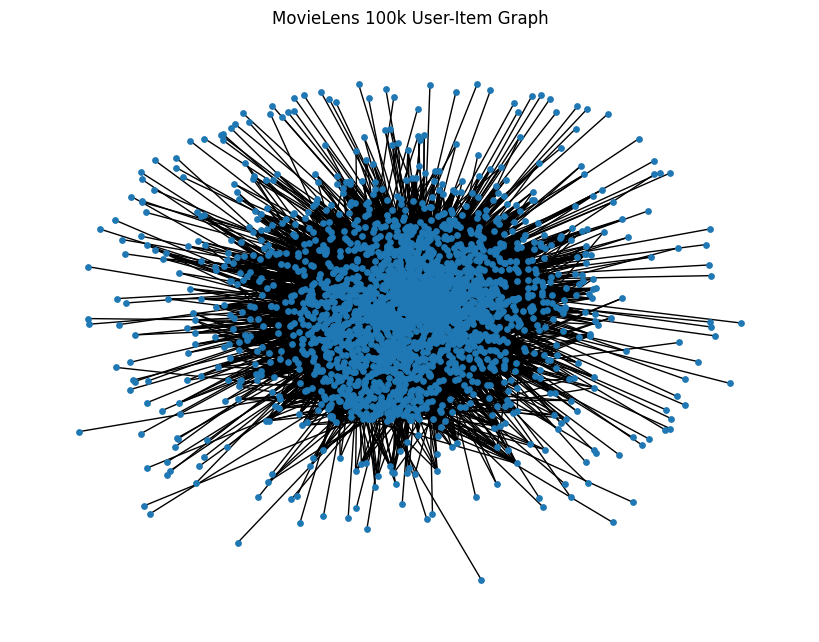

In [58]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 6))
nx.draw(G, node_size=15, with_labels=False)
plt.title("MovieLens 100k User-Item Graph")
plt.show()


Visualize User 10 and Their Connected Items

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


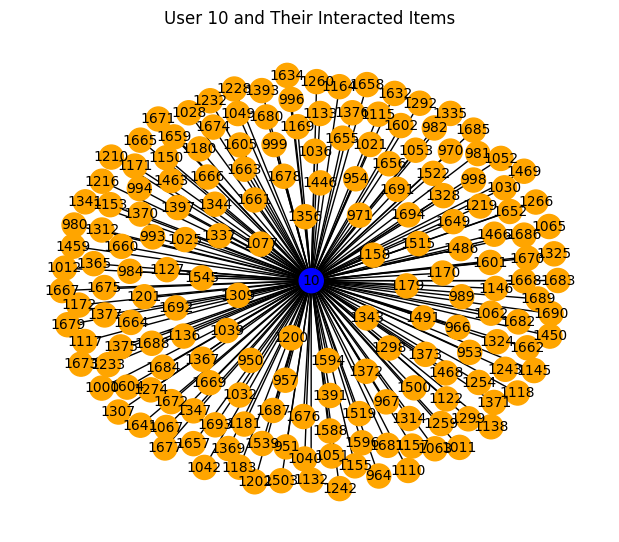

In [61]:
user_id = 10  # Index in encoded space, not original ID

# Get item nodes this user has interacted with
user_edges = data.edge_index[:, data.edge_index[0] == user_id]
connected_items = user_edges[1].tolist()

# Build the Subgraph
import networkx as nx
from torch_geometric.utils import to_networkx

# Create full graph
full_G = to_networkx(data, to_undirected=True)

# Define nodes for subgraph: user + connected items
sub_nodes = [user_id] + connected_items

# Create subgraph
sub_G = full_G.subgraph(sub_nodes)


# Visualize It

import matplotlib.pyplot as plt

# Custom coloring: user = blue, items = orange
color_map = ['blue' if node == user_id else 'orange' for node in sub_G.nodes]

plt.figure(figsize=(6, 5))
nx.draw(sub_G, with_labels=True, node_color=color_map, node_size=300, font_size=10)
plt.title(f"User {user_id} and Their Interacted Items")
plt.show()
